# Store Profile Classifier

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
transactions = pd.read_csv("/kaggle/input/dataset/Historical-transaction-data.csv")
storedata = pd.read_csv("/kaggle/input/dataset/Store-info.csv")
testdata = pd.read_csv("/kaggle/input/dataset/Testing-data.csv")

In [3]:
transactions.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,210,5


## Drop null values in transactions

In [4]:
transactions.isnull().sum()

item_description    35928
transaction_date        0
invoice_id           6320
customer_id             0
shop_id                 0
item_price              0
quantity_sold           0
dtype: int64

In [5]:
transactions = transactions.dropna()

In [6]:
transactions.isnull().sum()

item_description    0
transaction_date    0
invoice_id          0
customer_id         0
shop_id             0
item_price          0
quantity_sold       0
dtype: int64

In [7]:
unique_shops = transactions['shop_id'].nunique()
print(unique_shops)

124


Basically there are 124 shops in total, we'll create a dataset from the transaction data

In [8]:
storedata

,shop_id,shop_area_sq_ft,shop_profile
0,SHOP047,528,Moderate
1,SHOP009,676,High
2,SHOP083,676,Low
3,SHOP117,676,Low
4,SHOP042,676,Low
...,...,...,...
119,SHOP087,527,NaN
120,SHOP050,411,NaN
121,SHOP061,699,NaN
122,SHOP056,597,NaN


# Planned Features
### Implemented
- Total Sales volume (total_vol)
- Total number of unique customers (total_customers)
- Largest volume by date? Largest volume in a single day (single_day_max_vol) ?
- Smallest volume by date? (single_day_max_vol)
- Sales volume per square foot (vol_per_sq_ft)
- Total Number of unique items (total_unique_items)
- Total transactions (n_transactions)
- Number of recurring customers (customer_id_repeating and customer_id_unique)
- Number of customers who visited only once (customer_id_single)

### Not yet implemented

### Target variable is shop_profile

## Adding total_vol and vol_per_sq_ft

In [9]:
# Compute the total volume of transactions for each store_id in the dataset dataframe
total_vol_by_store = transactions.groupby('shop_id').apply(lambda x: (x['item_price'] * x['quantity_sold']).sum())

total_vol_by_store = total_vol_by_store.rename('total_vol')

# Merge the total_vol_by_store series with the storedata dataframe on the 'store_id' column
storedata = pd.merge(storedata, total_vol_by_store, on='shop_id', how='left')
storedata["vol_per_sq_ft"] = storedata["total_vol"] / storedata["shop_area_sq_ft"]
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft
0,SHOP047,528,Moderate,737810,1397.367424
1,SHOP009,676,High,1677355,2481.294379
2,SHOP083,676,Low,1550195,2293.187870
3,SHOP117,676,Low,2100835,3107.744083
4,SHOP042,676,Low,1194170,1766.523669
...,...,...,...,...,...
119,SHOP087,527,NaN,1082565,2054.203036
120,SHOP050,411,NaN,2160700,5257.177616
121,SHOP061,699,NaN,2026220,2898.741059
122,SHOP056,597,NaN,2587840,4334.740369


## Adding total_customers

In [10]:
# group the transactions dataframe by shop_id and count the number of unique customer_ids
unique_customers = transactions.groupby('shop_id')['customer_id'].nunique()

# add a new column to the storedata dataframe with the counts of unique customers
storedata['total_customers'] = storedata['shop_id'].map(unique_customers)

In [11]:
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers
0,SHOP047,528,Moderate,737810,1397.367424,841
1,SHOP009,676,High,1677355,2481.294379,2210
2,SHOP083,676,Low,1550195,2293.187870,1719
3,SHOP117,676,Low,2100835,3107.744083,1898
4,SHOP042,676,Low,1194170,1766.523669,1661
...,...,...,...,...,...,...
119,SHOP087,527,NaN,1082565,2054.203036,1014
120,SHOP050,411,NaN,2160700,5257.177616,1696
121,SHOP061,699,NaN,2026220,2898.741059,1657
122,SHOP056,597,NaN,2587840,4334.740369,2638


## Adding total_unique_items

In [12]:
# group the transactions dataframe by shop_id and count the number of unique item_descriptions
unique_items = transactions.groupby('shop_id')['item_description'].nunique()

# add a new column to the storedata dataframe with the counts of unique items
storedata['total_unique_items'] = storedata['shop_id'].map(unique_items)

## Adding single_day_max_vol

In [13]:
transactions['single_day_max_vol'] = transactions['item_price'] * transactions['quantity_sold']
total_volume_per_day = transactions.groupby(['shop_id', 'transaction_date'])['single_day_max_vol'].sum().reset_index()
highest_volume_per_shop = total_volume_per_day.groupby('shop_id')['single_day_max_vol'].max().reset_index()

storedata = pd.merge(storedata, highest_volume_per_shop, on='shop_id')

## Adding single_day_min_vol

In [14]:
transactions['single_day_min_vol'] = transactions['item_price'] * transactions['quantity_sold']
total_volume_per_day = transactions.groupby(['shop_id', 'transaction_date'])['single_day_min_vol'].sum().reset_index()
highest_volume_per_shop = total_volume_per_day.groupby('shop_id')['single_day_min_vol'].min().reset_index()

storedata = pd.merge(storedata, highest_volume_per_shop, on='shop_id')

In [15]:
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_max_vol,single_day_min_vol
0,SHOP047,528,Moderate,737810,1397.367424,841,35,70050,1180
1,SHOP009,676,High,1677355,2481.294379,2210,35,83250,7190
2,SHOP083,676,Low,1550195,2293.187870,1719,35,67490,7015
3,SHOP117,676,Low,2100835,3107.744083,1898,35,79690,4920
4,SHOP042,676,Low,1194170,1766.523669,1661,35,68485,3995
...,...,...,...,...,...,...,...,...,...
119,SHOP087,527,NaN,1082565,2054.203036,1014,35,119750,1500
120,SHOP050,411,NaN,2160700,5257.177616,1696,31,84680,6415
121,SHOP061,699,NaN,2026220,2898.741059,1657,35,474620,3960
122,SHOP056,597,NaN,2587840,4334.740369,2638,35,157005,9865


## Adding n_transactions

In [16]:
# group transactions by shop_id and count the number of unique invoice_ids
transaction_counts = transactions.groupby('shop_id')['invoice_id'].nunique()

# add a new column to storedata with the transaction counts for each shop
storedata['n_transactions'] = storedata['shop_id'].map(transaction_counts)

In [17]:
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_max_vol,single_day_min_vol,n_transactions
0,SHOP047,528,Moderate,737810,1397.367424,841,35,70050,1180,1174
1,SHOP009,676,High,1677355,2481.294379,2210,35,83250,7190,3087
2,SHOP083,676,Low,1550195,2293.187870,1719,35,67490,7015,2476
3,SHOP117,676,Low,2100835,3107.744083,1898,35,79690,4920,2949
4,SHOP042,676,Low,1194170,1766.523669,1661,35,68485,3995,2256
...,...,...,...,...,...,...,...,...,...,...
119,SHOP087,527,NaN,1082565,2054.203036,1014,35,119750,1500,1407
120,SHOP050,411,NaN,2160700,5257.177616,1696,31,84680,6415,3019
121,SHOP061,699,NaN,2026220,2898.741059,1657,35,474620,3960,2245
122,SHOP056,597,NaN,2587840,4334.740369,2638,35,157005,9865,4026


## Adding customer_id_repeating, customer_id_unique and customer_id_single

In [18]:
# Get a dataframe with the number of unique customers who visited each shop
unique_visits = transactions.groupby(['shop_id'])['customer_id'].nunique()

# Get a dataframe with the number of customers who visited each shop more than once
repeat_customers = transactions.groupby(['shop_id', 'customer_id']).size().reset_index(name='counts')
repeat_customers = repeat_customers[repeat_customers['counts'] > 1].groupby('shop_id')['customer_id'].nunique()

# Get a dataframe with the number of customers who visited each shop only once
single_visits = transactions.groupby(['shop_id'])['customer_id'].nunique() - repeat_customers
single_visits = single_visits.reset_index()
single_visits = single_visits.rename(columns={'customer_id': 'customer_id_single'})

# Merge the three dataframes on shop_id and add new columns to storedata
storedata = storedata.merge(unique_visits, on='shop_id')
storedata = storedata.merge(repeat_customers, on='shop_id',suffixes=('_unique', '_repeating'))
storedata = storedata.merge(single_visits, on='shop_id')



In [19]:
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_max_vol,single_day_min_vol,n_transactions,customer_id_unique,customer_id_repeating,customer_id_single
0,SHOP047,528,Moderate,737810,1397.367424,841,35,70050,1180,1174,841,285,556
1,SHOP009,676,High,1677355,2481.294379,2210,35,83250,7190,3087,2210,763,1447
2,SHOP083,676,Low,1550195,2293.187870,1719,35,67490,7015,2476,1719,626,1093
3,SHOP117,676,Low,2100835,3107.744083,1898,35,79690,4920,2949,1898,772,1126
4,SHOP042,676,Low,1194170,1766.523669,1661,35,68485,3995,2256,1661,533,1128
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,SHOP087,527,NaN,1082565,2054.203036,1014,35,119750,1500,1407,1014,370,644
120,SHOP050,411,NaN,2160700,5257.177616,1696,31,84680,6415,3019,1696,777,919
121,SHOP061,699,NaN,2026220,2898.741059,1657,35,474620,3960,2245,1657,596,1061
122,SHOP056,597,NaN,2587840,4334.740369,2638,35,157005,9865,4026,2638,1012,1626


## Checking Correlation

<AxesSubplot:>

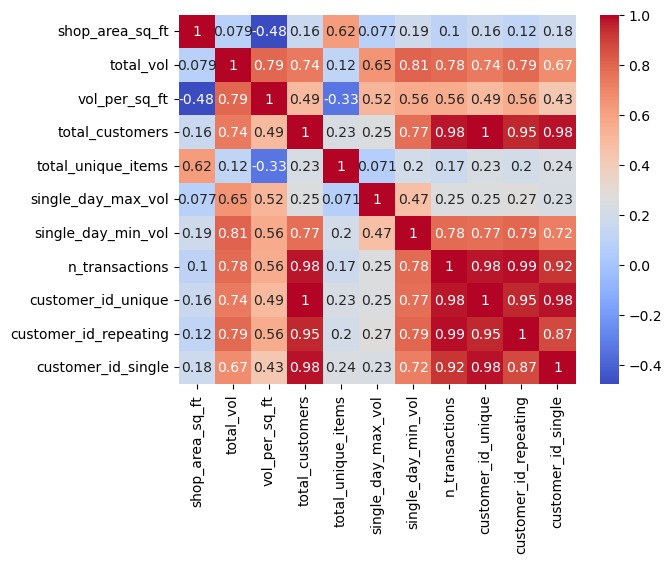

In [20]:
# create a correlation matrix
corr_matrix = storedata.corr()

# create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)

In [21]:
storedata.columns

Index(['shop_id', 'shop_area_sq_ft', 'shop_profile', 'total_vol',
       'vol_per_sq_ft', 'total_customers', 'total_unique_items',
       'single_day_max_vol', 'single_day_min_vol', 'n_transactions',
       'customer_id_unique', 'customer_id_repeating', 'customer_id_single'],
      dtype='object')

## Selected Features


In [22]:
all = ['shop_area_sq_ft', 'total_vol',
       'vol_per_sq_ft', 'total_customers', 'total_unique_items',
       'single_day_max_vol', 'single_day_min_vol', 'n_transactions',
       'customer_id_unique', 'customer_id_repeating', 'customer_id_single']

drop_set = ["single_day_max_vol","customer_id_single"]
storedata = storedata.drop(drop_set,axis = 1)

## Train test split (basically removing the testing data specified)

In [23]:
# Create a boolean mask for filtering shopdata
mask = storedata['shop_id'].isin(testdata['shop_id'])

# Create two separate dataframes
test_shops = storedata[mask]
train_shops = storedata[~mask]

In [24]:
test_shops = test_shops.drop('shop_profile', axis=1)
test_shops

,shop_id,shop_area_sq_ft,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,n_transactions,customer_id_unique,customer_id_repeating
100,SHOP046,545,2530320,4642.788991,1650,35,8005,2612,1650,640
101,SHOP024,676,1226605,1814.504438,1526,35,4730,2132,1526,517
102,SHOP023,617,2348545,3806.393841,2007,35,9660,2851,2007,693
103,SHOP097,310,1933680,6237.677419,1562,31,6730,2282,1562,577
104,SHOP044,715,1150160,1608.615385,1441,35,4800,1938,1441,461
105,SHOP030,530,2624575,4952.028302,1567,35,5845,2657,1567,679
106,SHOP038,411,1382505,3363.759124,1711,31,5045,2489,1711,598
107,SHOP029,597,1759365,2947.010050,1886,35,5420,2647,1886,667
108,SHOP096,676,2390780,3536.656805,2295,35,7490,3435,2295,886
109,SHOP092,617,1666250,2700.567261,2044,35,6560,2668,2044,638


In [25]:
train_shops

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,n_transactions,customer_id_unique,customer_id_repeating
0,SHOP047,528,Moderate,737810,1397.367424,841,35,1180,1174,841,285
1,SHOP009,676,High,1677355,2481.294379,2210,35,7190,3087,2210,763
2,SHOP083,676,Low,1550195,2293.187870,1719,35,7015,2476,1719,626
3,SHOP117,676,Low,2100835,3107.744083,1898,35,4920,2949,1898,772
4,SHOP042,676,Low,1194170,1766.523669,1661,35,3995,2256,1661,533
...,...,...,...,...,...,...,...,...,...,...,...
95,SHOP124,606,High,2638685,4354.265677,2134,35,12315,3038,2134,783
96,SHOP012,336,Low,936300,2786.607143,1196,31,2380,1782,1196,379
97,SHOP093,705,High,1586575,2250.460993,1391,35,3515,1734,1391,432
98,SHOP004,516,Low,1489415,2886.463178,1644,35,5280,2506,1644,636


## Encoding the target variable 

### Ordinal encoding
0 = Low
1 = Moderate
2 = High

In [26]:
from sklearn.preprocessing import LabelEncoder
pd.options.mode.chained_assignment = None  # default='warn'

# Define the mapping of labels to integer codes
label_mapping = {
    'Low': 0,
    'Moderate': 1,
    'High': 2
}

# Create an instance of the LabelEncoder
encoder = LabelEncoder()

# Fit the encoder to the shop_profile column in train_shops
train_shops['shop_profile'] = encoder.fit_transform(train_shops['shop_profile'].map(label_mapping))


In [27]:
train_shops

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,n_transactions,customer_id_unique,customer_id_repeating
0,SHOP047,528,1,737810,1397.367424,841,35,1180,1174,841,285
1,SHOP009,676,2,1677355,2481.294379,2210,35,7190,3087,2210,763
2,SHOP083,676,0,1550195,2293.187870,1719,35,7015,2476,1719,626
3,SHOP117,676,0,2100835,3107.744083,1898,35,4920,2949,1898,772
4,SHOP042,676,0,1194170,1766.523669,1661,35,3995,2256,1661,533
...,...,...,...,...,...,...,...,...,...,...,...
95,SHOP124,606,2,2638685,4354.265677,2134,35,12315,3038,2134,783
96,SHOP012,336,0,936300,2786.607143,1196,31,2380,1782,1196,379
97,SHOP093,705,2,1586575,2250.460993,1391,35,3515,1734,1391,432
98,SHOP004,516,0,1489415,2886.463178,1644,35,5280,2506,1644,636


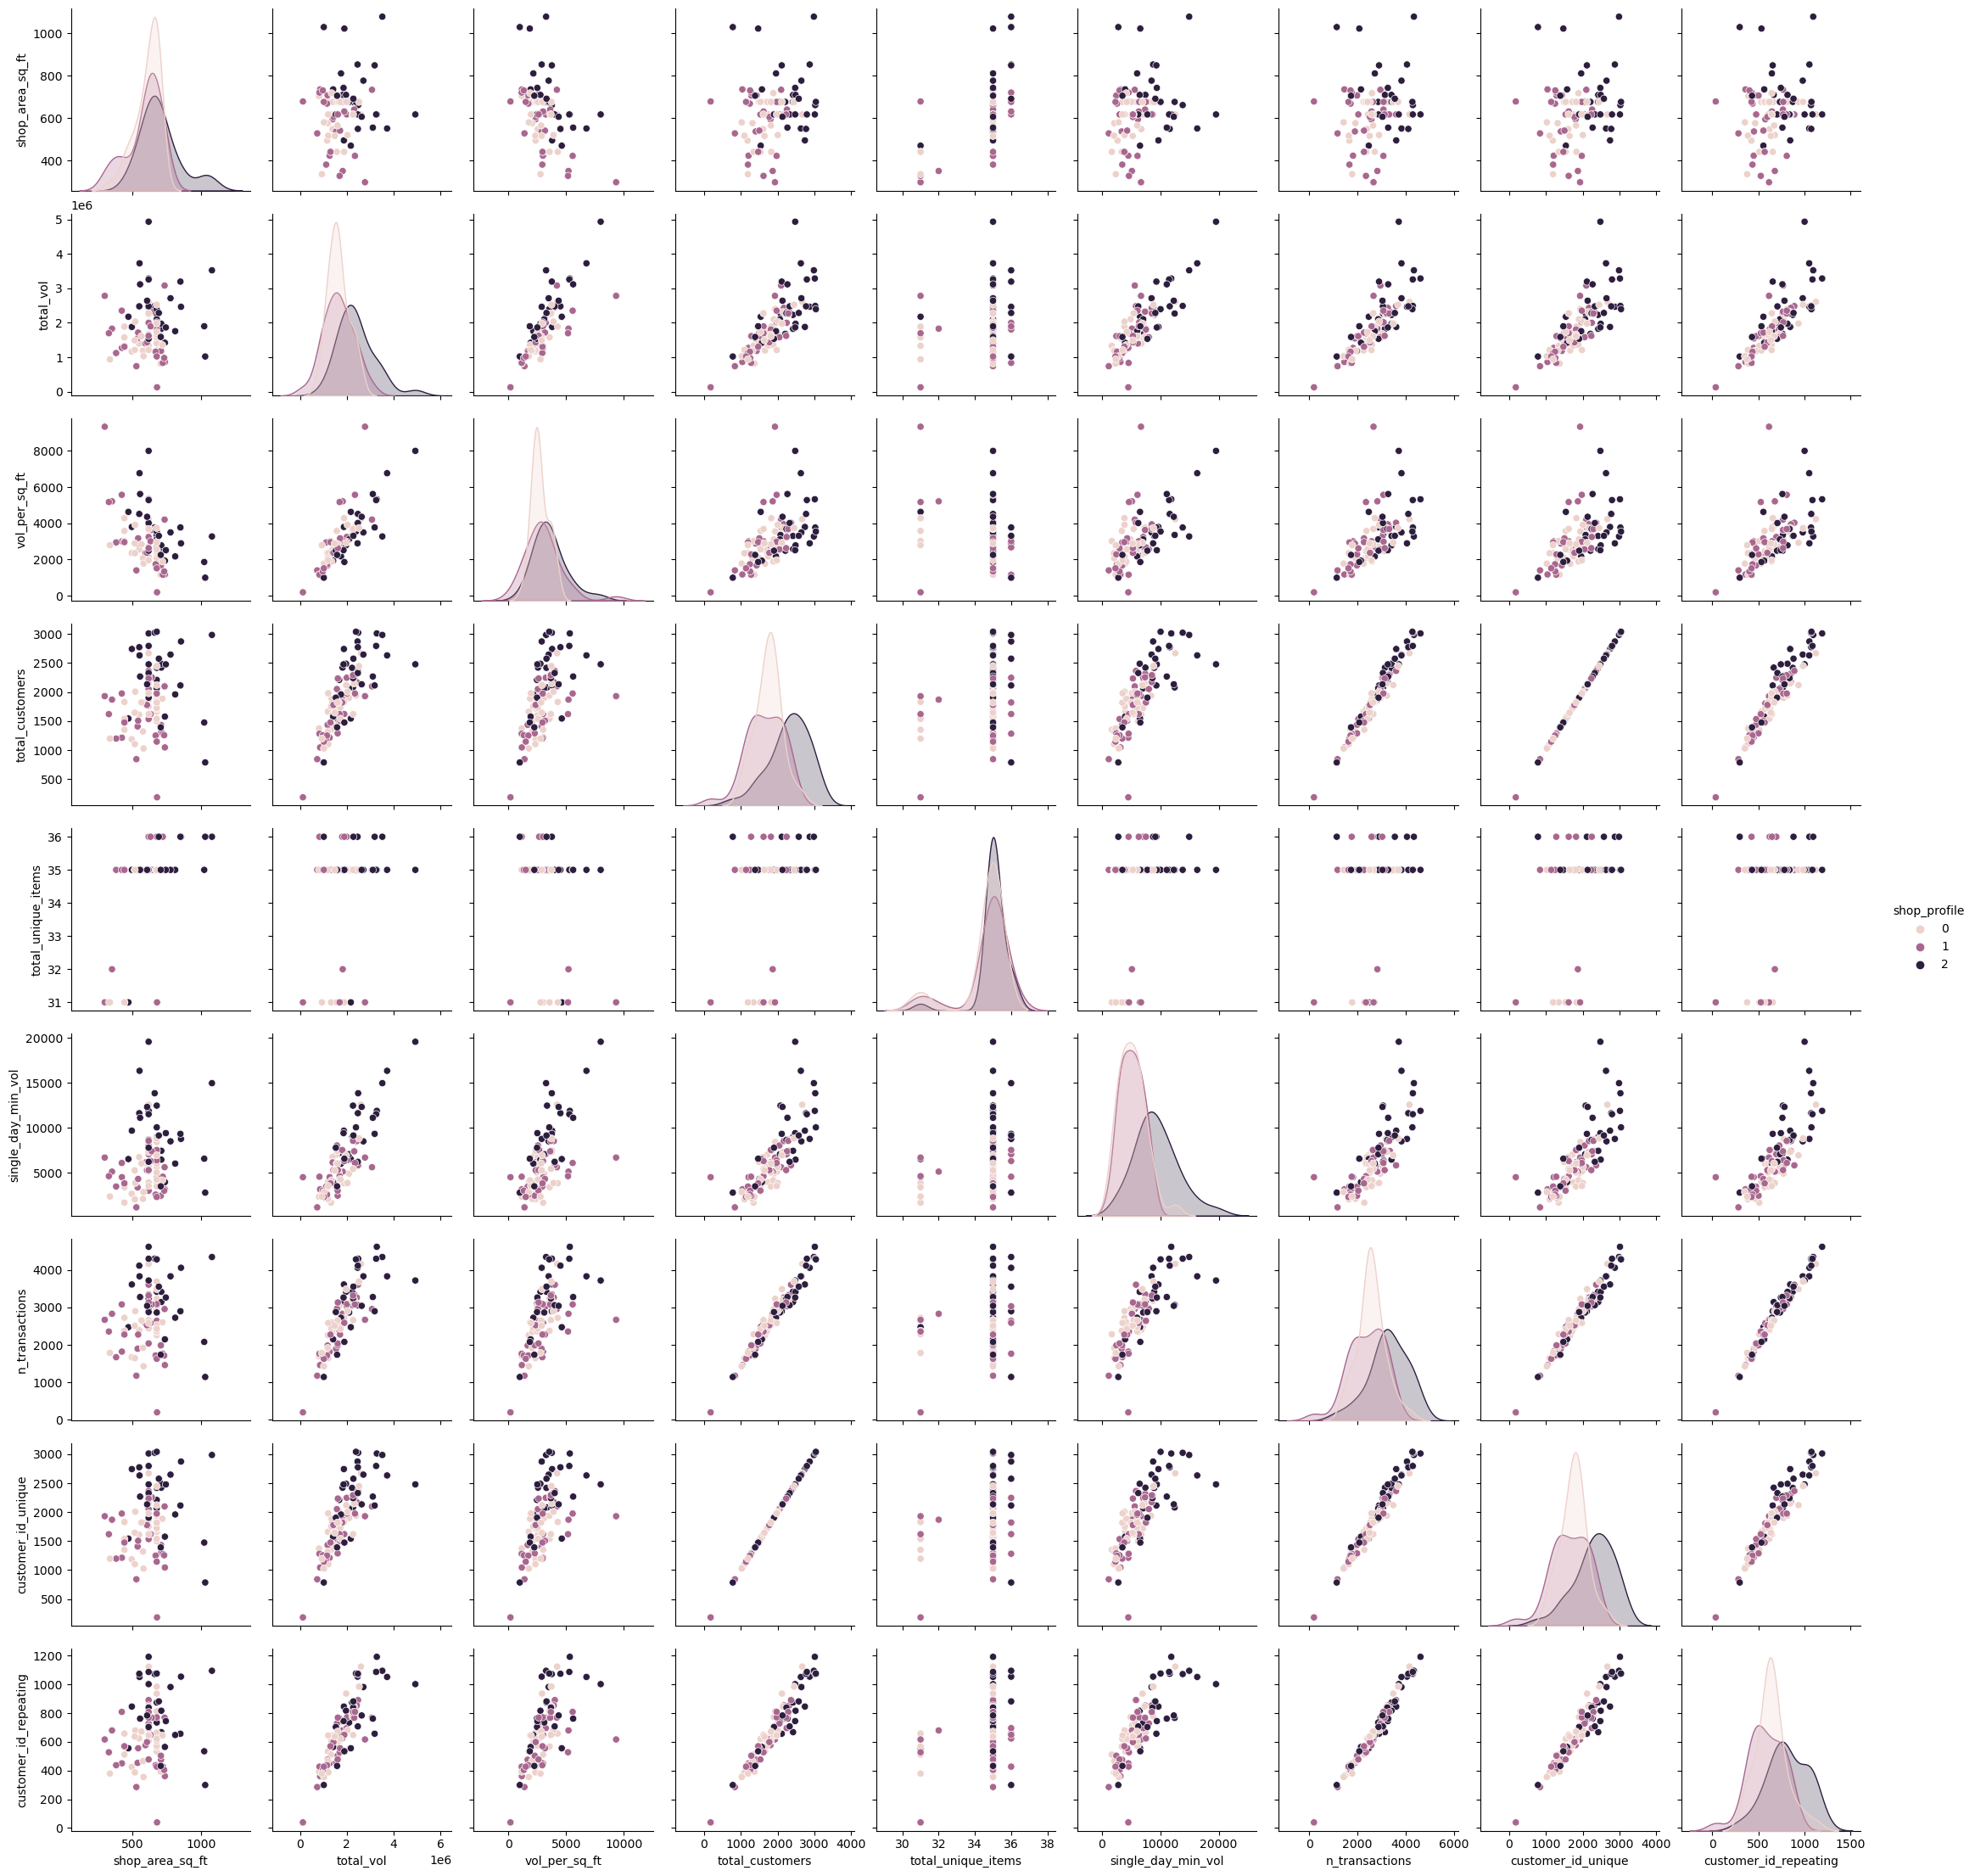

In [28]:
sns.pairplot(train_shops, hue='shop_profile')

## Spliting for crossvalidation

In [29]:
y = train_shops['shop_profile']
X = train_shops.drop('shop_profile', axis=1)
X = X.drop('shop_id',axis = 1)

In [30]:
y

0     1
1     2
2     0
3     0
4     0
     ..
95    2
96    0
97    2
98    0
99    2
Name: shop_profile, Length: 100, dtype: int64

In [31]:
X

,shop_area_sq_ft,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,n_transactions,customer_id_unique,customer_id_repeating
0,528,737810,1397.367424,841,35,1180,1174,841,285
1,676,1677355,2481.294379,2210,35,7190,3087,2210,763
2,676,1550195,2293.187870,1719,35,7015,2476,1719,626
3,676,2100835,3107.744083,1898,35,4920,2949,1898,772
4,676,1194170,1766.523669,1661,35,3995,2256,1661,533
...,...,...,...,...,...,...,...,...,...
95,606,2638685,4354.265677,2134,35,12315,3038,2134,783
96,336,936300,2786.607143,1196,31,2380,1782,1196,379
97,705,1586575,2250.460993,1391,35,3515,1734,1391,432
98,516,1489415,2886.463178,1644,35,5280,2506,1644,636


### Train test split

In [32]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

## Training the model

In [33]:
train_X

,shop_area_sq_ft,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,n_transactions,customer_id_unique,customer_id_repeating
48,720,833485,1157.618056,1281,36,4575,1762,1281,427
6,617,2319650,3759.562399,2315,35,7425,3344,2315,852
99,691,2283270,3304.298119,2576,36,9150,3550,2576,881
82,605,1430240,2364.033058,1777,35,5305,2521,1777,598
76,617,3256765,5278.387358,2796,35,11510,4294,2796,1086
...,...,...,...,...,...,...,...,...,...
96,336,936300,2786.607143,1196,31,2380,1782,1196,379
67,520,2032615,3908.875000,2006,35,3880,2897,2006,679
64,617,2273330,3684.489465,2241,35,8655,3236,2241,838
47,617,1611115,2611.207455,1534,35,3030,2036,1534,477


In [34]:
train_y

48    1
6     1
99    2
82    1
76    2
     ..
96    0
67    0
64    2
47    1
44    1
Name: shop_profile, Length: 75, dtype: int64

In [35]:
val_X

,shop_area_sq_ft,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,n_transactions,customer_id_unique,customer_id_repeating
26,594,1396875,2351.641414,1806,35,6160,2576,1806,576
86,441,1303060,2954.784580,1475,35,3840,2272,1475,569
2,676,1550195,2293.187870,1719,35,7015,2476,1719,626
55,661,2487645,3763.456884,3024,35,13835,4297,3024,1071
75,549,2476295,4510.555556,2774,35,11620,4109,2774,1073
93,555,3114935,5612.495495,2268,35,11110,3273,2268,761
16,495,1877700,3793.333333,2743,35,9680,3608,2743,845
73,541,1714300,3168.761553,1505,35,4330,2272,1505,555
54,617,2430920,3939.902755,2171,35,8530,3260,2171,853
95,606,2638685,4354.265677,2134,35,12315,3038,2134,783


In [36]:
val_y

26    1
86    1
2     0
55    2
75    2
93    2
16    2
73    1
54    1
95    2
53    2
92    0
78    1
13    1
7     1
30    2
22    2
24    0
33    0
8     0
43    1
62    2
3     0
71    1
45    0
Name: shop_profile, dtype: int64

### Training model

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [38]:
# Define the model with default hyperparameters
model = XGBClassifier()
# model = KNeighborsClassifier(n_neighbors= 25)
# model = RandomForestClassifier(n_estimators=100,random_state=1)

# Fit the model to the training data
model.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

## Making predictions

In [39]:
# Make predictions on the test data
y_pred = model.predict(val_X)

## F1 Score

In [40]:
from sklearn.metrics import f1_score

# Calculate the F1 score
f1 = f1_score(val_y, y_pred,average='micro')

# Print the result
print("F1 score:", f1)

F1 score: 0.6


## For submissions Train using full X and y sets

In [41]:
# Define the model with default hyperparameters
FinalModel = XGBClassifier()
# FinalModel = KNeighborsClassifier(n_neighbors=3)
# FinalModel = RandomForestClassifier(n_estimators=100,random_state=1)

# Fit the model to the training data
FinalModel.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [42]:
test_shops = test_shops.drop('shop_id', axis=1)
test_shops

,shop_area_sq_ft,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,n_transactions,customer_id_unique,customer_id_repeating
100,545,2530320,4642.788991,1650,35,8005,2612,1650,640
101,676,1226605,1814.504438,1526,35,4730,2132,1526,517
102,617,2348545,3806.393841,2007,35,9660,2851,2007,693
103,310,1933680,6237.677419,1562,31,6730,2282,1562,577
104,715,1150160,1608.615385,1441,35,4800,1938,1441,461
105,530,2624575,4952.028302,1567,35,5845,2657,1567,679
106,411,1382505,3363.759124,1711,31,5045,2489,1711,598
107,597,1759365,2947.010050,1886,35,5420,2647,1886,667
108,676,2390780,3536.656805,2295,35,7490,3435,2295,886
109,617,1666250,2700.567261,2044,35,6560,2668,2044,638


In [43]:
FinalPred = FinalModel.predict(test_shops)

In [44]:
len(FinalPred)

24

## Combining predictions with shop_id

In [45]:
# Create a dictionary mapping the old values to the new values
mapping = {0: 'Low', 1: 'Moderate', 2: 'High'}

# Map the values in the 'shop_profile' column using the dictionary
testdata["shop_profile"] = FinalPred

In [46]:
testdata

,shop_id,shop_profile
0,SHOP046,1
1,SHOP024,0
2,SHOP023,2
3,SHOP097,1
4,SHOP044,1
5,SHOP030,1
6,SHOP038,0
7,SHOP029,1
8,SHOP096,1
9,SHOP092,0


In [47]:
# Define a dictionary to map values to labels
label_map = {0: 'Low', 1: 'Moderate', 2: 'High'}

# Replace the values in the shop_profile column with labels
testdata['shop_profile'] = testdata['shop_profile'].replace(label_map)

In [48]:
## Write to CSV
testdata.to_csv('output.csv', index=False)
print("Done!!")

Done!!
